### Домашнее задание 8

1.   Возьмите англо-русскую пару фраз
2.   Обучите на них seq2seq with attention:

● на основе скалярного произведения

● на основе MLP

3. Оцените качество

In [1]:
from IPython.display import clear_output

In [2]:
!pip install pycodestyle pycodestyle_magic
!pip install flake8
clear_output()

In [3]:
%load_ext pycodestyle_magic

In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from itertools import chain
from tqdm.notebook import tqdm
from warnings import filterwarnings
from datetime import datetime, timedelta

%matplotlib inline

In [5]:
filterwarnings('ignore')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
import subprocess

# Замените URL на тот, который вы хотите загрузить
url = 'https://www.manythings.org/anki/rus-eng.zip'
output_path = '/Users/wizard/Yandex.Disk.localized/data s/HW/DLL'

# Выполните команду wget с помощью subprocess
subprocess.call(['wget', '-O', output_path, url])


FileNotFoundError: [Errno 2] No such file or directory: 'wget'

In [9]:
!wget https://www.manythings.org/anki/rus-eng.zip

zsh:1: command not found: wget


In [8]:
!unzip rus-eng.zip

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [9]:
!rm rus-eng.zip _about.txt

In [14]:
df = pd.read_csv('eng-rus.txt', sep='\t', header=None).drop(2, axis=1)

In [11]:
df.head(10)

,0,1
0,Go.,Марш!
1,Go.,Иди.
2,Go.,Идите.
3,Hi.,Здравствуйте.
4,Hi.,Привет!
5,Hi.,Хай.
6,Hi.,Здрасте.
7,Hi.,Здоро́во!
8,Hi.,Приветик!
9,Run!,Беги!


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464010 entries, 0 to 464009
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       464010 non-null  object
 1   1       464010 non-null  object
dtypes: object(2)
memory usage: 7.1+ MB


In [16]:
df[0] = df[0].apply(lambda x: re.sub(r'[^a-zа-яё \']+', '', x.lower()))
df[1] = df[1].apply(lambda x: re.sub(r'[^a-zа-яё \']+', '', x.lower()))
df[0] = df[0].apply(lambda x: re.sub(r'\s\s+|\'', ' ', x))
df[1] = df[1].apply(lambda x: re.sub(r'\s\s+|\'', ' ', x))

In [17]:
df.sample(n=10)

,0,1
78509,tom can t leave now,тому нельзя сейчас уходить
314290,tom didn t ask for my permission,том не спрашивал моего разрешения
147412,tom and mary are dating,том и мэри встречаются
448177,tom and mary got married when they were both t...,том и мария поженились когда им обоим было по ...
334411,doing that will be a piece of cake,сделать это будет проще простого
278294,please help me clean the house,помоги мне убрать дом пожалуйста
12860,she hated him,она его ненавидела
159536,i know you re kidding me,я знаю что вы меня разыгрываете
101534,can you wait a minute,можете подождать минутку
422339,tom will probably want to stay until monday,том возможно захочет остаться до понедельника


In [18]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [19]:
pairs = list(zip(df[0].tolist(), df[1].tolist()))

In [20]:
del df

In [21]:
pairs = filterPairs(pairs)

In [22]:
len(pairs)

29332

In [23]:
eng_dict = ['SOS', 'EOS'] + sorted(
    list(set(chain.from_iterable([pair[0].split() for pair in pairs])))
    )

In [24]:
len(eng_dict)

4445

In [25]:
eng_dict[:10]

['SOS',
 'EOS',
 'a',
 'abandon',
 'ability',
 'able',
 'aboard',
 'about',
 'above',
 'abroad']

In [26]:
rus_dict = ['SOS', 'EOS'] + sorted(
    list(set(chain.from_iterable([pair[1].split() for pair in pairs])))
    )

In [27]:
len(rus_dict)

10704

In [28]:
rus_dict[:10]

['SOS',
 'EOS',
 'android',
 'linux',
 'windows',
 'а',
 'абсолютно',
 'абсолютной',
 'авантюрен',
 'авантюризма']

In [29]:
eng_to_idx = {elem: i for i, elem in enumerate(eng_dict)}
rus_to_idx = {elem: i for i, elem in enumerate(rus_dict)}

In [30]:
def tensors_from_pair(pair):
    eng_idx = [0] + [eng_to_idx[word] for word in pair[0].split()]
    eng_idx += [1] * (MAX_LENGTH + 1 - len(pair[0].split()))
    rus_idx = [0] + [rus_to_idx[word] for word in pair[1].split()]
    rus_idx += [1] * (MAX_LENGTH + 1 - len(pair[1].split()))
    eng_tensor = torch.tensor(eng_idx, dtype=torch.long,
                              device=device).view(-1, 1)
    rus_tensor = torch.tensor(rus_idx, dtype=torch.long,
                              device=device).view(-1, 1)
    return (eng_tensor, rus_tensor)

In [31]:
pair = pairs[np.random.randint(27003)]
print(pair)
print(tensors_from_pair(pair))

('i m sorry i hurt tom', 'мне жаль что я причинил тому боль')
(tensor([[   0],
        [1934],
        [2332],
        [3606],
        [1934],
        [1925],
        [4010],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1]]), tensor([[    0],
        [ 4106],
        [ 2220],
        [10430],
        [10658],
        [ 7257],
        [ 9446],
        [  509],
        [    1],
        [    1],
        [    1],
        [    1]]))


##### Encoder

In [32]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

##### Attention Decoder (на скалярном произведении)

In [33]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1,
                 max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length + 2

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        weights = []
        for i in range(len(encoder_outputs)):
            weights.append(
                torch.div(torch.matmul(hidden[0][0], encoder_outputs[i]),
                          torch.sqrt(
                              torch.tensor(self.max_length, dtype=torch.float,
                                           device=device))
                          )
                )
        attn_weights = F.softmax(torch.tensor(weights, device=device))

        attn_applied = torch.bmm(attn_weights.unsqueeze(0).unsqueeze(0),
                                 encoder_outputs.view(1, -1, self.hidden_size)
                                 )

        output = torch.cat((attn_applied[0], embedded[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

##### Функции для обучения и оценки качества

In [34]:
teacher_forcing_ratio = 0.5

In [35]:
def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion, max_len=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_outputs = torch.zeros(max_len + 2, encoder.hidden_size,
                                  device=device)
    loss = 0

    for i in range(input_tensor.size(0)):
        encoder_output, encoder_hidden = encoder(input_tensor[i],
                                                 encoder_hidden)
        encoder_outputs[i] = encoder_output[0, 0]

    decoder_input = torch.tensor([[0]], device=device)
    decoder_hidden = encoder_hidden

    if np.random.random() < teacher_forcing_ratio:
        use_teacher_forcing = True
    else:
        use_teacher_forcing = False

    for i in range(target_tensor.size(0)):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs
            )
        loss += criterion(decoder_output, target_tensor[i])
        if use_teacher_forcing:
            # teacher forcing: feed the target as the next input
            decoder_input = target_tensor[i]
        else:
            # use its own predictions as the next input
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            if decoder_input.item() == 1:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_tensor.size(0)

In [36]:
def train_epochs(encoder, decoder, n_epochs=75000, learning_rate=0.01):
    start = datetime.now()
    plot_losses = []
    print_loss = 0 # reset every 5000 epochs
    plot_loss = 0 # reset every 100 epochs
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensors_from_pair(pairs[np.random.randint(27003)])
                      for epoch in range(n_epochs)]
    criterion = nn.NLLLoss()

    for epoch in tqdm(range(n_epochs)):
        training_pair = training_pairs[epoch]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        print_loss += loss
        plot_loss += loss

        if (epoch + 1) % 5000 == 0:
            print_loss /= 5000
            delta = datetime.now() - start
            stats = f'''
            Epoch {epoch + 1} ({(epoch + 1) * 100 / n_epochs:.1f}%)
            Time: {delta.seconds // 60}m {delta.seconds % 60}s
            Loss: {print_loss:.4f}
            '''
            print(stats)
            print_loss = 0

        if (epoch + 1) % 100 == 0:
            plot_loss /= 100
            plot_losses.append(plot_loss)
            plot_loss = 0
    return plot_losses

In [37]:
def show_losses(losses):
    plt.figure(figsize=(14, 12))
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(losses)
    plt.show()

In [38]:
def evaluate(encoder, decoder, sent, max_len=MAX_LENGTH):
    with torch.no_grad():
        idx = [0] + [eng_to_idx[word] for word in sent.split()]
        idx += [1] * (max_len + 1 - len(sent.split()))
        input_tensor = torch.tensor(idx, dtype=torch.long,
                                    device=device).view(-1, 1)
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_len + 2, encoder.hidden_size,
                                      device=device)

        for i in range(input_tensor.size()[0]):
            encoder_output, encoder_hidden = encoder(input_tensor[i],
                                                     encoder_hidden)
            encoder_outputs[i] = encoder_output[0, 0]

        decoder_input = torch.tensor([[0]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_len + 2, max_len + 2)

        for i in range(max_len + 2):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[i] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == 1:
                break
            decoded_words.append(rus_dict[topi.item()])
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions

In [39]:
def evaluate_random(encoder, decoder, n=10):
    for i in range(n):
        pair = pairs[np.random.randint(27003)]
        pred = " ".join(evaluate(encoder, decoder, pair[0])[0][1:])
        res = f'''
        Eng:  {pair[0]}
        Rus:  {pair[1]}
        Pred: {pred}
        '''
        print(res)

##### Обучение и оценка качества

In [40]:
hidden_size = 256

In [41]:
encoder = EncoderRNN(len(eng_dict), hidden_size).to(device)

In [42]:
attn_decoder = AttnDecoderRNN(hidden_size, len(rus_dict)).to(device)

In [43]:
losses = train_epochs(encoder, attn_decoder)

  0%|          | 0/75000 [00:00<?, ?it/s]


            Epoch 5000 (6.7%)
            Time: 6m 30s
            Loss: 1.8875
            

            Epoch 10000 (13.3%)
            Time: 12m 45s
            Loss: 1.7329
            

            Epoch 15000 (20.0%)
            Time: 18m 52s
            Loss: 1.5586
            

            Epoch 20000 (26.7%)
            Time: 24m 50s
            Loss: 1.4769
            

            Epoch 25000 (33.3%)
            Time: 30m 48s
            Loss: 1.3785
            

            Epoch 30000 (40.0%)
            Time: 36m 53s
            Loss: 1.3071
            

            Epoch 35000 (46.7%)
            Time: 42m 54s
            Loss: 1.2143
            

            Epoch 40000 (53.3%)
            Time: 48m 53s
            Loss: 1.1745
            

            Epoch 45000 (60.0%)
            Time: 54m 51s
            Loss: 1.1204
            

            Epoch 50000 (66.7%)
            Time: 60m 54s
            Loss: 1.0715
            

            Epoch 55000 (73.3%)


<Figure size 1400x1200 with 0 Axes>

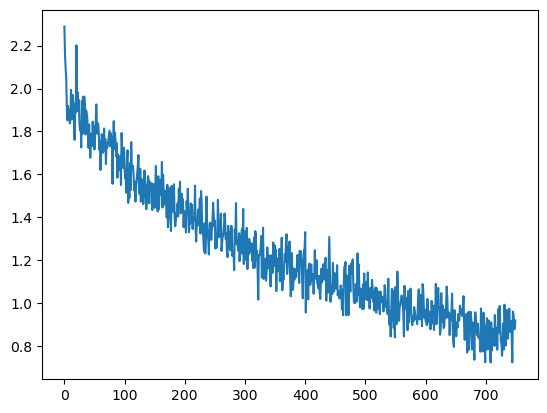

In [44]:
show_losses(losses)

Лосс стабильно падает, финальный лосс – 0.8672
. Посмотрим на генерацию предложений.

In [45]:
evaluate_random(encoder, attn_decoder)


        Eng:  you re not normal
        Rus:  ты ненормальная
        Pred: ты не
        

        Eng:  you re older than tom
        Rus:  вы старше тома
        Pred: ты старше тома
        

        Eng:  we re ready to help
        Rus:  мы готовы помочь
        Pred: мы готовы помочь
        

        Eng:  i m not like everybody else
        Rus:  я не все
        Pred: я не такой как все
        

        Eng:  i m working in australia now
        Rus:  я сейчас работаю в австралии
        Pred: сейчас я работаю в австралии
        

        Eng:  i m sure a solution can be found
        Rus:  я уверен что можно найти решение
        Pred: я уверен что могу найти найти
        

        Eng:  he s not the right man for you
        Rus:  он тебе не пара
        Pred: он для вас вас не
        

        Eng:  i m amazed tom is still alive
        Rus:  я поражена что том ещё жив
        Pred: я удивлён что том жив
        

        Eng:  he s always busy
        Rus:  он всегда

Два случайное предложение переведено полностью правильно, и 3 – правильно по смыслу (если учесть, что в английском нет родов и разграничения на "ты" и "вы")!

In [46]:
pair = pairs[np.random.randint(27003)]
print(pair)

('i m almost finished doing it', 'я с этим почти закончил')


In [47]:
output_words, attentions = evaluate(
    encoder, attn_decoder, pair[0])

In [48]:
attentions

tensor([[1.4148e-17, 9.6809e-19, 5.0453e-20, 1.2398e-15, 1.8825e-13, 1.4168e-11,
         9.0819e-10, 2.0098e-05, 2.9062e-03, 5.4803e-02, 2.9001e-01, 6.5226e-01],
        [1.5772e-13, 5.1459e-15, 3.4926e-14, 2.1416e-12, 4.4745e-10, 1.5265e-08,
         5.2468e-08, 1.9644e-04, 8.0316e-03, 7.4888e-02, 2.9596e-01, 6.2092e-01],
        [1.2641e-11, 5.1431e-12, 5.0344e-12, 1.2252e-09, 1.7274e-07, 3.8593e-06,
         1.3817e-05, 4.6508e-03, 4.1135e-02, 1.4998e-01, 3.2973e-01, 4.7449e-01],
        [6.7117e-09, 8.6855e-09, 5.1138e-09, 1.1385e-07, 1.4979e-05, 3.5831e-04,
         7.2357e-04, 1.5356e-02, 6.2457e-02, 1.7313e-01, 3.2739e-01, 4.2058e-01],
        [1.2433e-06, 7.1399e-07, 1.8802e-07, 3.1425e-06, 6.3024e-04, 1.2204e-02,
         6.8475e-02, 6.0690e-02, 8.9943e-02, 1.6999e-01, 2.7280e-01, 3.2526e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0

In [49]:
attentions.numpy()[0]

array([1.4148369e-17, 9.6808980e-19, 5.0452899e-20, 1.2397673e-15,
       1.8824551e-13, 1.4168475e-11, 9.0819230e-10, 2.0097505e-05,
       2.9061907e-03, 5.4803174e-02, 2.9001248e-01, 6.5225810e-01],
      dtype=float32)

<Figure size 1400x1200 with 0 Axes>

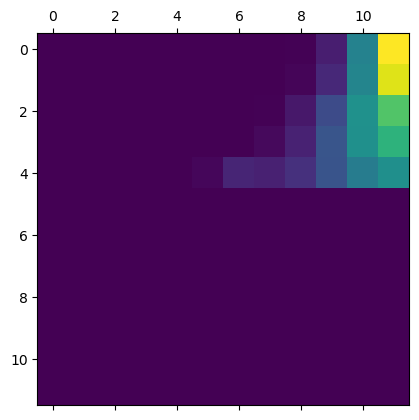

In [50]:
plt.figure(figsize=(14, 12))
plt.matshow(attentions.numpy())
plt.show()

In [51]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words + ['<EOS>'])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [52]:
def evaluate_show_attention(sent):
    output_words, attentions = evaluate(
        encoder, attn_decoder, sent)
    print('input =', sent)
    print('output =', ' '.join(output_words[1:]))
    showAttention(sent, output_words[1:], attentions)

input = i m happy tom liked it
output = я так рад за


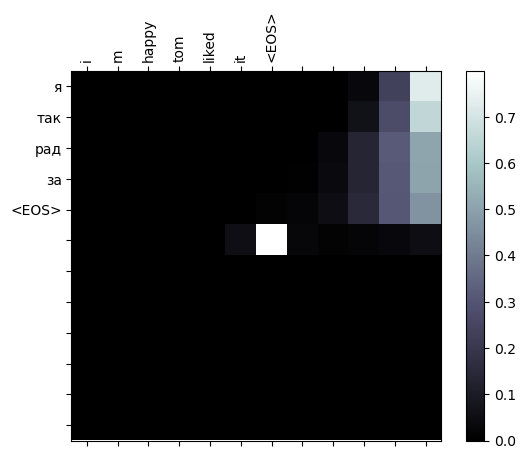

In [53]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = you re successful
output = ты трус


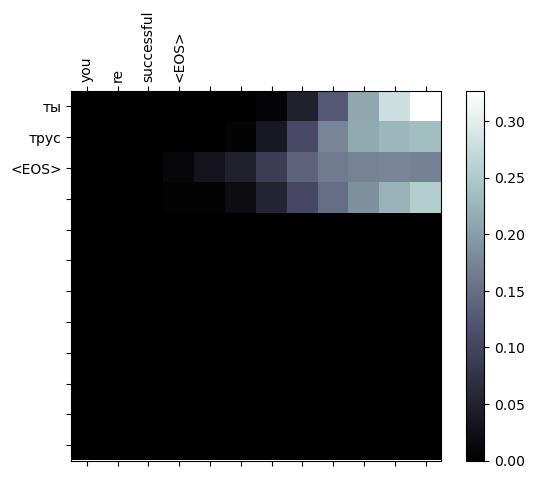

In [54]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = i m not ashamed of what we did
output = мне не стыдно что я


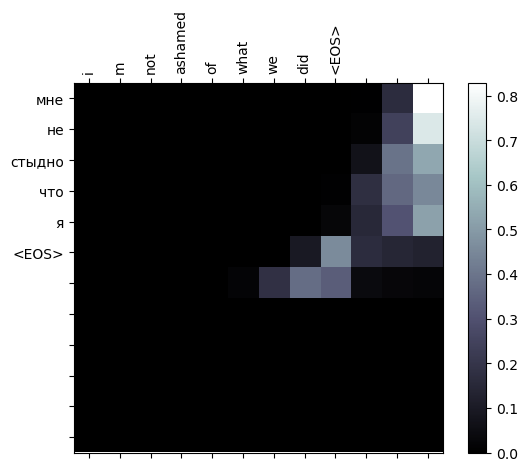

In [55]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = she suffocated him with a pillow
output = она слегла с с


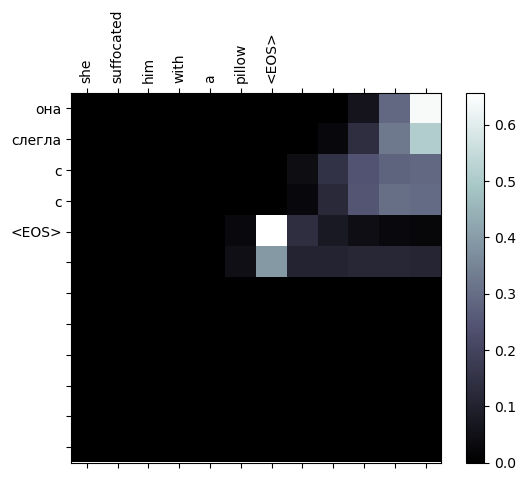

In [56]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

##### Attention Decoder (на MLP)

In [57]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.attn = nn.Linear(self.hidden_size * 2, 1)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        weights = []
        for i in range(len(encoder_outputs)):
            weights.append(
                torch.tanh(self.attn(torch.cat((hidden[0][0],
                                                encoder_outputs[i]))))
                )
        attn_weights = F.softmax(torch.tensor(weights, device=device))

        attn_applied = torch.bmm(attn_weights.unsqueeze(0).unsqueeze(0),
                                 encoder_outputs.view(1, -1, self.hidden_size)
                                 )

        output = torch.cat((attn_applied[0], embedded[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

##### Обучение и оценка качества

In [58]:
hidden_size = 256

In [59]:
encoder = EncoderRNN(len(eng_dict), hidden_size).to(device)

In [60]:
attn_decoder = AttnDecoderRNN(hidden_size, len(rus_dict)).to(device)

In [61]:
losses = train_epochs(encoder, attn_decoder)

  0%|          | 0/75000 [00:00<?, ?it/s]


            Epoch 5000 (6.7%)
            Time: 4m 48s
            Loss: 1.9339
            

            Epoch 10000 (13.3%)
            Time: 9m 39s
            Loss: 1.7297
            

            Epoch 15000 (20.0%)
            Time: 61m 50s
            Loss: 1.5903
            

            Epoch 20000 (26.7%)
            Time: 116m 26s
            Loss: 1.5008
            

            Epoch 25000 (33.3%)
            Time: 121m 7s
            Loss: 1.4175
            

            Epoch 30000 (40.0%)
            Time: 125m 56s
            Loss: 1.3275
            

            Epoch 35000 (46.7%)
            Time: 130m 58s
            Loss: 1.2524
            

            Epoch 40000 (53.3%)
            Time: 135m 51s
            Loss: 1.2011
            

            Epoch 45000 (60.0%)
            Time: 141m 17s
            Loss: 1.1326
            

            Epoch 50000 (66.7%)
            Time: 146m 45s
            Loss: 1.0880
            

            Epoch 55000 (73

<Figure size 1400x1200 with 0 Axes>

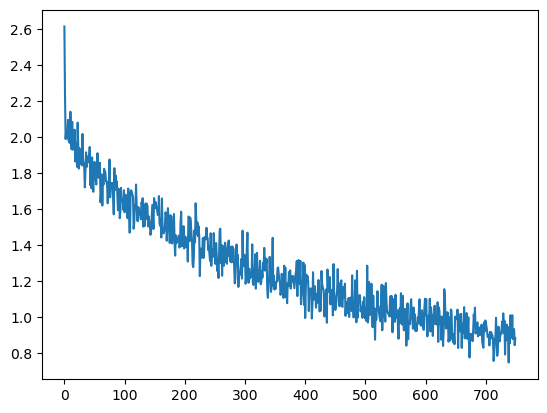

In [62]:
show_losses(losses)

Обучается  дольше, чем seq2seq с attention на скалярном произведении (175 минут  против 89 минут), финальный loss лучше, чем у сети с attention на скалярном произведении (0.90 против 0.86). Посмотрим на генерацию предложений.

In [60]:
evaluate_random(encoder, attn_decoder)


        Eng:  you re not going to wear that are you
        Rus:  ты ведь не собираешься это носить правда
        Pred: ты ведь не собираешься
        

        Eng:  they re the only ones tom can trust
        Rus:  они единственные кому том может доверять
        Pred: ты единственный кому кому доверять
        

        Eng:  i m glad the rumors weren t true
        Rus:  я рад что слухи не подтвердились
        Pred: я рад что что не не
        

        Eng:  you re making a serious mistake
        Rus:  вы совершаете серьёзную ошибку
        Pred: ты совершаешь ошибку ошибку
        

        Eng:  we re not the murderers
        Rus:  мы не убийцы
        Pred: мы не не
        

        Eng:  i m younger than he is
        Rus:  я моложе его
        Pred: я моложе него
        

        Eng:  you re not my friend
        Rus:  ты мне не друг
        Pred: ты мне не подруга
        

        Eng:  he is dead and buried now
        Rus:  сейчас он мёртв и предан земле
        P

Предсказания  выглядят хуже, среди всех сгенерированных предложений только одно переведено правильно (в точности или по смыслу).

In [63]:
pair = pairs[np.random.randint(27003)]
print(pair)

('i m experienced', 'я опытный')


In [64]:
output_words, attentions = evaluate(
    encoder, attn_decoder, pair[0])

In [65]:
attentions

tensor([[0.1105, 0.0830, 0.1050, 0.0883, 0.0733, 0.0703, 0.0741, 0.0767, 0.0783,
         0.0794, 0.0802, 0.0809],
        [0.1086, 0.0832, 0.1038, 0.0883, 0.0737, 0.0707, 0.0745, 0.0771, 0.0787,
         0.0797, 0.0805, 0.0811],
        [0.1112, 0.0829, 0.1056, 0.0883, 0.0731, 0.0702, 0.0739, 0.0766, 0.0782,
         0.0793, 0.0801, 0.0807],
        [0.1087, 0.0832, 0.1038, 0.0883, 0.0737, 0.0707, 0.0745, 0.0771, 0.0787,
         0.0797, 0.0805, 0.0811],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [66]:
attentions.numpy()[0]

array([0.11045113, 0.08302008, 0.10504665, 0.08831812, 0.07325596,
       0.07029189, 0.07407375, 0.07674405, 0.07833934, 0.07940205,
       0.08020046, 0.08085649], dtype=float32)

<Figure size 1400x1200 with 0 Axes>

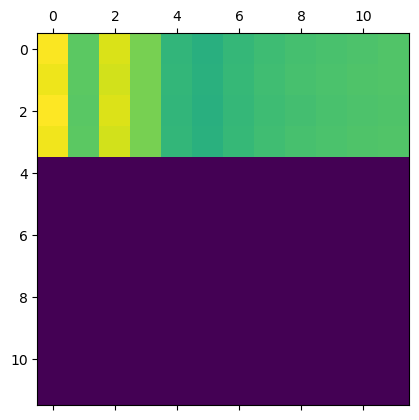

In [67]:
plt.figure(figsize=(14, 12))
plt.matshow(attentions.numpy())
plt.show()

input = i m afraid you can t go there
output = боюсь ты не туда туда туда туда


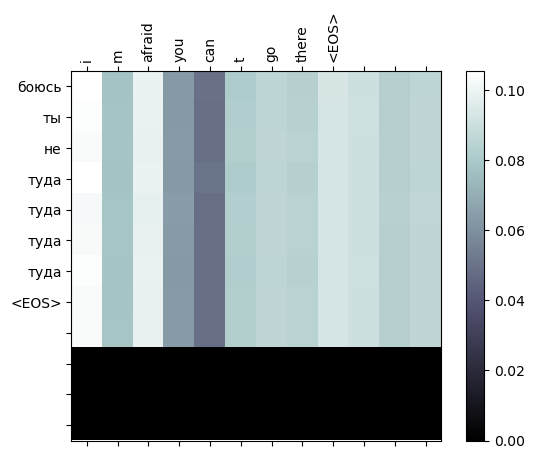

In [68]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = you re my neighbor
output = ты мой мой


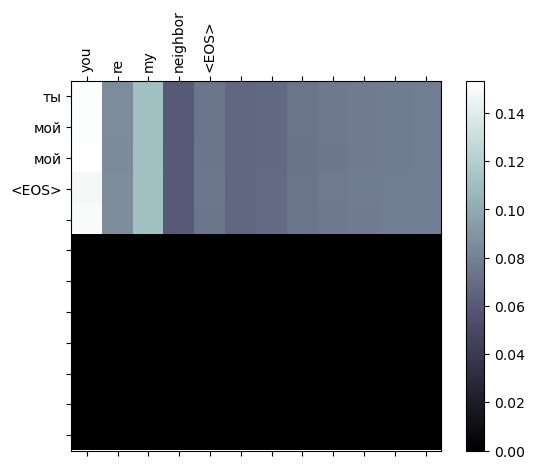

In [69]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = i m running short of cash
output = у меня нет еда


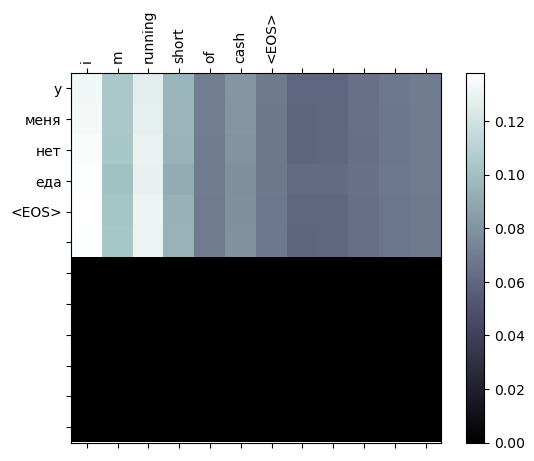

In [70]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = i m not counting on it
output = я не на на на


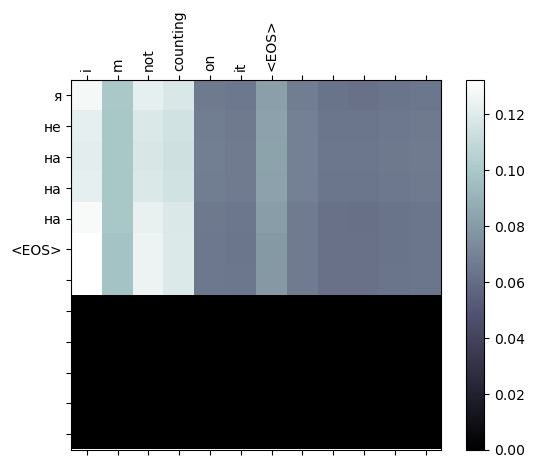

In [71]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])